In [8]:
%matplotlib inline
import cv2
from IPython.core.debugger import Tracer
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 2.4.12 


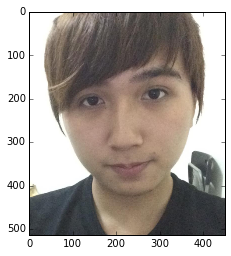

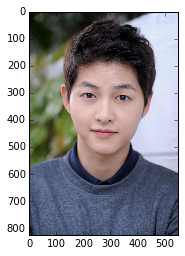

In [39]:
PATH = "yusheng.jpg"
PATH2 = "SongJoongKi.jpg"
img = cv2.imread(PATH)
r = 450.0 / img.shape[1]
dim = (450, int(img.shape[0] * r))
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

img2 = cv2.imread(PATH2)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img_org = img_rgb.copy()
img2_org = img_rgb2.copy()

plt.imshow(img_rgb)
plt.show()
plt.imshow(img_rgb2)
plt.show()


Number of faces detected: 1


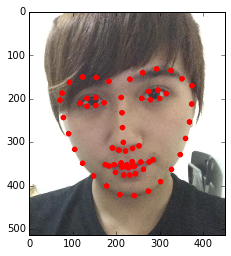

Number of faces detected: 1


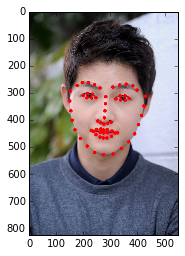

In [40]:
import sys
import os
import dlib
import glob
from skimage import io

def FacialPointDetector( img, img_rgb ) :
    predictor_path = "./shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
    #     print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
    #         k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
    #     print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
    #                                               shape.part(1)))
        fp = np.array([[p.x, p.y] for p in predictor(img, d).parts()])
        for i in range(0,68,1):
            cv2.circle( img_rgb, (fp[i][0], fp[i][1]), 6, (255,0,0), cv2.cv.CV_FILLED, cv2.CV_AA, 0 )
    
        return fp
 

fp = FacialPointDetector( img, img_rgb )
plt.imshow(img_rgb)
plt.show()

fp2 = FacialPointDetector( img2, img_rgb2 )
plt.imshow(img_rgb2)
plt.show()

Total Trangles: 112
112


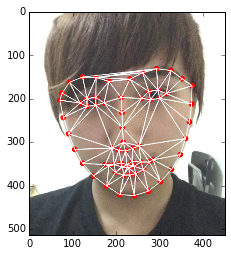

Total Trangles: 112


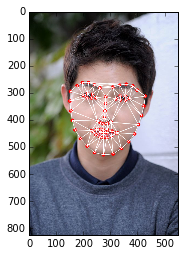

In [43]:
# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

def draw_delaunay(img, subdiv, delaunay_color, fp ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    trList = []
    lmList = [] #follow first triangulation 
    for t in triangleList :
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        id1 = 0
        id2 = 0
        id3 = 0
        for i in range(0,67,1):
            if pt1[0]==fp[i][0] and pt1[1]==fp[i][1]:
                id1=i
            if pt2[0]==fp[i][0] and pt2[1]==fp[i][1]:    
                id2=i
            if pt3[0]==fp[i][0] and pt3[1]==fp[i][1]:
                id3=i
                    
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.CV_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.CV_AA, 0)
            trList.append((pt1, pt2, pt3))
            lmList.append((id1, id2, id3))
                
    print( "Total Trangles: {}".format(len(trList)) )
    return trList, lmList
 
def DrawFacialTriangulation( img, img_rgb, fp ) :
    # Rectangle to be used with Subdiv2D
    size = img.shape
    rect = (0, 0, size[1], size[0])

    # Create an instance of Subdiv2D
    subdiv = cv2.Subdiv2D(rect);

    # #test
    # cv2.rectangle(img_rgb, (rect[0],rect[1]), (rect[2],rect[3]), (0, 255, 0), 10)
    # plt.imshow(img_rgb)
    # plt.show()

    # Insert points into subdiv
    for i in range(0,68,1):
        subdiv.insert((fp[i][0], fp[i][1]))

    # Draw delaunay triangles
    lmList = []
    trList, lmList = draw_delaunay( img_rgb, subdiv, (255, 255, 255), fp );
    return trList, lmList
    
trList, lmList = DrawFacialTriangulation( img, img_rgb, fp )
print(len(lmList))
triIdx = open("triIdx.txt", "w")
for i in range(0,len(lmList),1):
    #print("{} {}".format(i,lmList[i]))
    if i == len(lmList)-1:
        triIdx.write("{} {} {}".format(lmList[i][0],lmList[i][1],lmList[i][2]))
    else:
        triIdx.write("{} {} {}\n".format(lmList[i][0],lmList[i][1],lmList[i][2]))

triIdx.close()
plt.imshow(img_rgb)
plt.show()


trList2 = DrawFacialTriangulation( img2, img_rgb2, fp2 )
plt.imshow(img_rgb2)
plt.show()


In [140]:
cList = []
for i in range(0,len(trList),1):
    c = []
    c = ((trList[i][0][0]+trList[i][1][0]+trList[i][2][0])/3,(trList[i][0][1]+trList[i][1][1]+trList[i][2][1])/3)
    cList.append((c[0],c[1]))
    
print(len(trList)) 
print(len(cList))    

for i in range(0,len(cList)-1,1):
    for j in range(len(cList)-1,i,-1):
        if j-1>=i and ( cList[j][0] < cList[j-1][0] or (cList[j][0] == cList[j-1][0] and cList[j][1] < cList[j-1][1])):
            temp = cList[j]    
            cList[j] = cList[j-1]
            cList[j-1] = temp
            temp2 = trList[j]
            trList[j] = trList[j-1]
            trList[j-1] = temp2            
            
for i in range(0,len(cList)-1,1):
    print(cList[i])

136
136
(-488.0, 81.333333333333329)
(-465.66666666666669, -383.33333333333331)
(-464.66666666666669, -364.66666666666669)
(-458.33333333333331, -397.0)
(-442.66666666666669, -409.33333333333331)
(-376.33333333333331, -419.66666666666669)
(-309.0, -424.66666666666669)
(0.0, 0.0)
(56.0, 689.0)
(64.666666666666671, 713.33333333333337)
(75.333333333333329, 736.0)
(87.0, 201.0)
(88.0, 219.66666666666666)
(89.666666666666671, 756.33333333333337)
(94.333333333333329, 187.33333333333334)
(100.0, 247.66666666666666)
(108.0, -468.66666666666669)
(108.0, 773.66666666666663)
(108.66666666666667, 224.33333333333334)
(113.33333333333333, 191.33333333333334)
(115.33333333333333, 171.33333333333334)
(124.66666666666667, 238.33333333333334)
(126.66666666666667, 209.66666666666666)
(128.0, 304.0)
(128.0, 788.0)
(135.66666666666666, 167.66666666666666)
(138.66666666666666, 211.33333333333334)
(138.66666666666666, 326.66666666666669)
(144.0, 270.33333333333331)
(145.33333333333334, 204.66666666666666)
(1

110
(87.0, 201.0)
(88.0, 219.66666666666666)
(94.333333333333329, 187.33333333333334)
(100.0, 247.66666666666666)
(108.66666666666667, 224.33333333333334)
(113.33333333333333, 191.33333333333334)
(115.33333333333333, 171.33333333333334)
(124.66666666666667, 238.33333333333334)
(126.66666666666667, 209.66666666666666)
(128.0, 304.0)
(135.66666666666666, 167.66666666666666)
(138.66666666666666, 211.33333333333334)
(138.66666666666666, 326.66666666666669)
(144.0, 270.33333333333331)
(145.33333333333334, 204.66666666666666)
(145.66666666666666, 183.33333333333334)
(147.66666666666666, 359.66666666666669)
(158.33333333333334, 208.0)
(162.0, 338.33333333333331)
(162.33333333333334, 170.33333333333334)
(167.66666666666666, 361.66666666666669)
(168.33333333333334, 189.66666666666666)
(168.66666666666666, 378.0)
(178.66666666666666, 231.0)
(183.33333333333334, 353.0)
(185.0, 265.66666666666669)
(185.33333333333334, 375.33333333333331)
(186.0, 339.33333333333331)
(187.66666666666666, 189.6666666

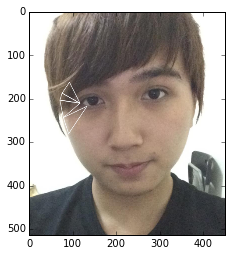

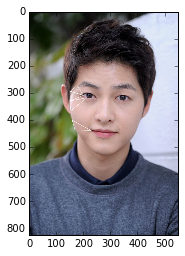

In [21]:
def TriangleSorting( trList ):
    # find all triangle incenters
    cList = []
    for i in range(0,len(trList),1):
        c = []
        d01 = pow( pow(trList[i][0][0]-trList[i][1][0], 2)+pow(trList[i][0][1]-trList[i][1][1], 2), 1/2)
        d12 = pow( pow(trList[i][1][0]-trList[i][2][0], 2)+pow(trList[i][1][1]-trList[i][2][1], 2), 1/2)
        d20 = pow( pow(trList[i][0][0]-trList[i][2][0], 2)+pow(trList[i][0][1]-trList[i][2][1], 2), 1/2)
        c = ((d12*trList[i][0][0]+d20*trList[i][1][0]+d01*trList[i][2][0])/(d01+d12+d20),
             (d12*trList[i][0][1]+d20*trList[i][1][1]+d01*trList[i][2][1])/(d01+d12+d20))
        cList.append((c[0],c[1]))
    
    # Sorting
    for i in range(0,len(cList)-1,1):
        for j in range(len(cList)-1,i,-1):
            if j-1>=i and ( cList[j][0] < cList[j-1][0] or 
                            (cList[j][0] == cList[j-1][0] and cList[j][1] < cList[j-1][1])):
                temp = cList[j]    
                cList[j] = cList[j-1]
                cList[j-1] = temp
                temp2 = trList[j]
                trList[j] = trList[j-1]
                trList[j-1] = temp2
                
    return trList, cList
  
def RemoveOuterTriangles( trList, rect ):
    i=0
    while i < len(trList): 
        t = [trList[i][0],trList[i][1],trList[i][2]]
        if ( rect_contains(rect, t[0])==False or rect_contains(rect, t[1])==False or 
             rect_contains(rect, t[2])==False ):
            del trList[i]
            i-=1
        
        i+=1
    
    return trList
    
def FaceMorphing( img, img2, fp, fp2, trList, trList2, alpha, img_org ):
    # Generated Facial Points 
    points = []
    
    # Compute weighted average point coordinates
    for i in range(0,67,1):
        x = int(( 1 - alpha ) * fp[i][0] + alpha * fp2[i][0])
        y = int(( 1 - alpha ) * fp[i][1] + alpha * fp2[i][1])
        points.append((x,y))
     
    # Allocate space for final output
    imgMorph = np.zeros(img.shape, dtype = img.dtype)
    
    # Rectangle to be used with Subdiv2D
    size = imgMorph.shape
    rect = (0, 0, size[1], size[0])
    size = img.shape
    img_rect1 = (0, 0, size[1], size[0])
    size2 = img2.shape
    img_rect2 = (0, 0, size2[1], size2[0])
        
    # Create an instance of Subdiv2D
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for i in range(0,67,1):
        subdiv.insert((points[i][0], points[i][1]))
    
    triangleListM = subdiv.getTriangleList();
    trListM = []
    for t in triangleListM :
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        trListM.append((pt1, pt2, pt3)) 
    
    # Sorting all traiangles
    trList = RemoveOuterTriangles( trList, img_rect1 )
    trList,cList = TriangleSorting( trList )
#     print( len(trList))
#     for i in range(0,len(cList),1):
#         print( cList[i] )
        
    
    print('-------------')
    trList2 = RemoveOuterTriangles( trList2, img_rect2 )
    trList2,cList2  = TriangleSorting( trList2 )
    
#     print( len(trList2))
#     for i in range(0,len(cList2),1):
#         print( cList2[i] )
    
    trListM = RemoveOuterTriangles( trListM, rect )
    trListM,cListM = TriangleSorting( trListM )

    j=1
    for i in range(0,len(trList),1) :
        # Get coordinates of a triangle
        t1 = [trList[i][0],trList[i][1],trList[i][2]]
        t2 = [trList2[i][0],trList2[i][1],trList2[i][2]]
        t = [trListM[i][0],trListM[i][1],trListM[i][2]]
        
        # Find bounding rectangle for each triangle
        r1 = cv2.boundingRect(np.float32([t1]))
        r2 = cv2.boundingRect(np.float32([t2]))
        r = cv2.boundingRect(np.float32([t]))

        cv2.line(img_org, t1[0], t1[1], (255, 255, 255), 1, cv2.CV_AA, 0)
        cv2.line(img_org, t1[1], t1[2], (255, 255, 255), 1, cv2.CV_AA, 0)
        cv2.line(img_org, t1[2], t1[0], (255, 255, 255), 1, cv2.CV_AA, 0)

        cv2.line(img2_org, t2[0], t2[1], (255, 255, 255), 1, cv2.CV_AA, 0)
        cv2.line(img2_org, t2[1], t2[2], (255, 255, 255), 1, cv2.CV_AA, 0)
        cv2.line(img2_org, t2[2], t2[0], (255, 255, 255), 1, cv2.CV_AA, 0)
        j+=1
            
        if j==5 :
            break
            
        
alpha = 0.5
FaceMorphing( img, img2, fp, fp2, trList, trList2, alpha, img_org )  
plt.imshow(img_org)
plt.show() 

plt.imshow(img2_org)
plt.show() 